In [1]:
# !pip install --upgrade scipy scikit-image

In [2]:
import os
import math
import numpy as np
import pandas as pd
import cv2
import random
# import pywt
# import scipy
# import nibabel as nib
from matplotlib import pyplot as plt
# from skimage.feature import local_binary_pattern
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Dense, Dropout
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPooling2D, Flatten, Dense, ReLU, Concatenate, Conv2DTranspose, UpSampling2D, BatchNormalization, Add, Softmax, GlobalAveragePooling2D, Reshape
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

from keras.models import Model
from keras.layers import Softmax, Lambda, Input, Conv2D, UpSampling2D, Dropout, MaxPooling2D, Concatenate, \
    BatchNormalization, Activation, Conv2DTranspose, LeakyReLU, Reshape
from keras.optimizers import Adam
from keras.layers import Layer
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend as K
from keras.losses import binary_crossentropy

2024-01-17 05:57:21.428530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 05:57:21.428565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 05:57:21.429334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 05:57:21.435081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 05:57:22.125525: W tensorflow/compiler/tf2

# **Image Presentation**

In [3]:
def present_processed_image(images, image_number):
    print(images.shape)

    fig = plt.figure(figsize=(10,5))
    
    for index in range(5):
        plt.subplot(1, 5, index+1)
        plt.imshow(images[image_number][:,:, index], cmap='gray')
        plt.axis("off")

#  **End to End Segmentation and Classifier Model**

In [4]:
class ImageDataGen(tf.keras.utils.Sequence):
  def __init__(self, dataset_path, 
                 folder_names,
                 batch_size,
                 shuffle=True):
#     self.data_path = os.getcwd()+"/"+dataset_path # for colab/pc
    self.data_path = dataset_path # for kaggle
    self.image_data_pkl_path = self.data_path+'/'+"image_data_pkl.pkl"
    self.image_data_pkl = pd.read_pickle(self.image_data_pkl_path)
    
    self.batch_size = batch_size
    self.process_image_name = ["anisotropic_img", "butterworth_img", "adaptive_median_img", "laplacian_img", "gabor_img"]

    self.folder_names = folder_names

    # calculate data length
    self.data_len = len(self.folder_names)

  def __len__(self):
    # number of possible batches
    # return self.data_len // self.batch_size
    return np.ceil(self.data_len / self.batch_size).astype("int")

  def __getitem__(self, index):
    from_index = index * self.batch_size
    to_index = (index + 1) * self.batch_size
    # add condition of last batch to_index
    if to_index > (self.data_len):
      to_index = self.data_len

    # take data of batch size
    batch_files = self.folder_names[from_index:to_index]

    batch_main_images = []
    batch_seg_images = []
    batch_processed_images = []
    batch_feature_vec = []
    batch_target = []

    for file_name in batch_files:
      # load feature vector
      target_type = self.image_data_pkl.loc[self.image_data_pkl['image_folder_name'] == file_name]['tumor_type'].values
      batch_target.append(target_type)
      feature_vec = np.array(self.image_data_pkl.loc[self.image_data_pkl['image_folder_name'] == file_name]['feature_vec'].values.copy()[0])
      batch_feature_vec.append(feature_vec)

      # load segmented image
      seg_target_path = self.data_path+"/"+file_name+"/"+"seg_target.jpg"
      seg_target_img = cv2.imread(seg_target_path)
      seg_target_img = cv2.cvtColor(seg_target_img, cv2.COLOR_BGR2GRAY)
      seg_target_img = np.expand_dims(seg_target_img, axis = 2).astype(float)
      batch_seg_images.append(seg_target_img/255.)

      # load main image
      main_target_path = self.data_path+"/"+file_name+"/"+"main.jpg"
      main_img = cv2.imread(main_target_path)
      main_img = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
      main_img = np.expand_dims(main_img, axis = 2).astype(float)
      batch_main_images.append(main_img/255.)

      # load preprocessed images
      process_images = []
      for process_name in self.process_image_name:
        process_img_path = self.data_path+"/"+file_name+"/"+process_name+".jpg"
        process_img = cv2.imread(process_img_path)
        process_img = cv2.cvtColor(process_img, cv2.COLOR_BGR2GRAY)
        process_images.append(process_img.astype(float)/255.)
      # shape (5, 240, 240)
      process_images = np.array(process_images)
      # process image final shape (240, 240, 5)
      process_images = np.moveaxis(process_images, 0, -1)
      batch_processed_images.append(process_images)

    batch_processed_images = np.array(batch_processed_images)
    batch_main_images = np.array(batch_main_images)
    batch_seg_images = np.array(batch_seg_images)
    batch_feature_vec = np.array(batch_feature_vec).astype(float)
    batch_target = np.array(batch_target).astype(float)
    # Y shape is tuple of (BATCH_SIZE, 240, 240, 1), (BATCH_SIZE, 1)
    # X shape is tuple of (BATCH_SIZE, 240, 240, 1), (BATCH_SIZE, 240, 240, 5), (BATCH_SIZE, 75)
    return tuple([batch_main_images, batch_processed_images, batch_feature_vec]), tuple([batch_seg_images, batch_target])
#     return tuple([batch_main_images, batch_processed_images, batch_feature_vec]), batch_seg_images

def data_gen_fn(dataset_path, batch_size, train=True):
    all_files = os.listdir(dataset_path)
    folder_names = []
    for name in all_files:
      temp_path = dataset_path+"/"+name
      if os.path.isdir(temp_path):
        folder_names.append(name)
    random.shuffle(folder_names)
    
    train_folder_names = folder_names[:math.floor(len(folder_names)*0.7)]
    test_folder_names = folder_names[math.floor(len(folder_names)*0.7):math.floor(len(folder_names)*0.9)]
    val_folder_names = folder_names[math.floor(len(folder_names)*0.9):math.floor(len(folder_names))]
    # test
#     folder_names = folder_names[:10]
    

    train_loader = ImageDataGen(dataset_path, train_folder_names, batch_size = BATCH_SIZE)
    test_loader = ImageDataGen(dataset_path, test_folder_names, batch_size = BATCH_SIZE)
    val_loader = ImageDataGen(dataset_path, val_folder_names, batch_size = BATCH_SIZE)
    
    return train_loader, test_loader, val_loader

In [5]:
class SegPredict():
  def __init__(self, loader):
    self.loader = loader
    
  def predict(self, model):
    for data in self.loader:
        seg_out = model(data[0])
    
    return seg_out, data[0], data[1]

In [6]:
class BiasNet(Layer):
    def __init__(self, **kwargs):
        super(BiasNet, self).__init__(**kwargs)
        self.kernel = None

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1, 1, input_shape[3]),
                                      initializer='he_normal',
                                      trainable=True)
        super(BiasNet, self).build(input_shape)

    def call(self, x, **kwargs):
        return x + self.kernel

    def compute_output_shape(self, input_shape):
        return input_shape
    
class HyperCNN(Layer):
    def __init__(self, x_dim, y_dim, ch_in, ch_out):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.num_c = int(ch_in * ch_out)

        self.bias_net = BiasNet()
        self.bn = BatchNormalization()

        # For p_kernal
        self.conv1 = Conv2D(16, (1, 1), padding='same', activation=None, use_bias=True, kernel_initializer='he_normal')
        self.conv2 = Conv2D(16, (1, 1), padding='same', activation=None, use_bias=True, kernel_initializer='he_normal')
        self.conv3 = Conv2D(4, (1, 1), padding='same', activation=None, use_bias=True, kernel_initializer='he_normal')
        self.conv4 = Conv2D(self.num_c, (1, 1), padding='same', activation=None, use_bias=True, kernel_initializer='he_normal')
        self.lrelu = LeakyReLU(alpha=0.1)

    def p_conv(self, ip, kernal):
        pos = tf.squeeze(kernal, axis=0)
        out = tf.nn.convolution(ip, pos, padding='SAME')
        # out = Activation('relu')(out)
        return out

    def p_kernal(self, ip, x_dim, y_dim, ch_in, ch_out):
        pos = self.conv1(ip)
        pos = self.lrelu(pos)

        pos = self.conv2(pos)
        pos = self.lrelu(pos)

        pos = self.conv3(pos)
        pos = self.lrelu(pos)

        pos = self.conv4(pos)
        pos = Reshape((x_dim, y_dim, ch_in, ch_out))(pos)
        return pos

    def hyperNet(self, x_dim=3, y_dim=3, ch_in=64, ch_out=64):
        xx_range = tf.range(-(x_dim - 1) / 2, (x_dim + 1) / 2, dtype='float32')
        yy_range = tf.range(-(y_dim - 1) / 2, (y_dim + 1) / 2, dtype='float32')

        xx_range = tf.tile(tf.expand_dims(xx_range, -1), [1, y_dim])
        yy_range = tf.tile(tf.expand_dims(yy_range, 0), [x_dim, 1])

        xx_range = tf.expand_dims(xx_range, -1)
        yy_range = tf.expand_dims(yy_range, -1)

        pos = tf.concat([xx_range, yy_range], -1)

        pos = tf.expand_dims(pos, 0)

        return pos

    def call(self, ip):
        input_channel = self.ch_in
        kernal1 = Lambda(lambda x: self.hyperNet(self.x_dim, self.y_dim, input_channel, self.ch_out))(ip)
        kernal1 = self.p_kernal(kernal1, self.x_dim, self.y_dim, input_channel, self.ch_out)
        n = Lambda(lambda x: self.p_conv(x[0], x[1]))([ip, kernal1])
        n = self.bias_net(n)
        return Activation("relu")(n)

class Shallow_CNN(layers.Layer):
    def __init__(self, input_shape=(None, 240, 240, 1)):
        super().__init__()
        self.conv1 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu', input_shape=input_shape, padding='same',
                           kernel_initializer='HeNormal')
        self.conv2 = Conv2D(1, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                            padding='same', kernel_initializer='HeNormal')
        self.bn = BatchNormalization()
        self.relu = ReLU()

    def call(self, x):
        x = tf.expand_dims(x, axis=-1, name=None)
        x = self.conv1(x)
        x = self.bn(x)
        x = self.conv2(x)
       
        return x

class Fully_Connected_Network(layers.Layer):
    def __init__(self, input_shape= (None, 75)):
        super().__init__()
        self.dense1 = Dense(128, activation='relu', input_shape=input_shape)
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(5, activation='tanh')
        self.bn = BatchNormalization()

    def call(self, x):
        x = self.dense1(x)
#         x = self.bn(x)
        x = self.dense2(x)
#         x = self.bn(x)
        x = self.dense3(x)
#         x = self.bn(x)
        return x

class Shallow_Fully_Model(layers.Layer):
    def __init__(self):
        super().__init__()
        self.fully_connected = Fully_Connected_Network()
        self.shallow_1 = Shallow_CNN()
        self.shallow_2 = Shallow_CNN()
        self.shallow_3 = Shallow_CNN()
        self.shallow_4 = Shallow_CNN()
        self.shallow_5 = Shallow_CNN()

    def call(self, input_images, wavelet_features_vec):
        x_fully = self.fully_connected(wavelet_features_vec)
        weighted_images = []

        # print(tf.is_symbolic_tensor(input_images))
        # print(tf.is_symbolic_tensor(x_fully))

        # weight_shallow_cnn_outputs

        x1 = self.shallow_1(input_images[:,:,:,0])
        x2 = self.shallow_2(input_images[:,:,:,1])
        x3 = self.shallow_3(input_images[:,:,:,2])
        x4 = self.shallow_4(input_images[:,:,:,3])
        x5 = self.shallow_5(input_images[:,:,:,4])
        
        x_fully_1 = tf.expand_dims(tf.expand_dims(tf.expand_dims(x_fully[:,0], axis=-1), axis=-1), axis = -1)
        x_fully_2 = tf.expand_dims(tf.expand_dims(tf.expand_dims(x_fully[:,1], axis=-1), axis=-1), axis = -1)
        x_fully_3 = tf.expand_dims(tf.expand_dims(tf.expand_dims(x_fully[:,2], axis=-1), axis=-1), axis = -1)
        x_fully_4 = tf.expand_dims(tf.expand_dims(tf.expand_dims(x_fully[:,3], axis=-1), axis=-1), axis = -1)
        x_fully_5 = tf.expand_dims(tf.expand_dims(tf.expand_dims(x_fully[:,4], axis=-1), axis=-1), axis = -1)
        
        x1 = tf.multiply(x1, x_fully_1)
        x2 = tf.multiply(x2, x_fully_2)
        x3 = tf.multiply(x3, x_fully_3)
        x4 = tf.multiply(x4, x_fully_4)
        x5 = tf.multiply(x5, x_fully_5)

        weighted_images = [x1, x2, x3, x4, x5]


        return tf.concat(weighted_images, axis=-1)

class Classifer_Tumor(layers.Layer):
    def __init__(self, kernel_size = (5,5), stride = 2):
        super().__init__()
        self.conv_layer1 = Conv2D(512, kernel_size=kernel_size, strides=(stride, stride),
                                 activation='relu', padding="valid",kernel_initializer='HeNormal')
        self.conv_layer2 = Conv2D(512, kernel_size=kernel_size, strides=(stride, stride),
                                 activation='relu', padding="valid", kernel_initializer='HeNormal')
        self.conv_layer3 = Conv2D(512, kernel_size=kernel_size, strides=(stride, stride), 
                                 activation='relu',padding="valid", kernel_initializer='HeNormal')
        self.padding = layers.ZeroPadding2D(padding=(1, 1))
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.dense3 = Dense(16, activation='relu')
        self.dense4 = Dense(1, activation='sigmoid')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.flatten = tf.keras.layers.Flatten()
    def call(self, input_conv):
        x = self.padding(input_conv)
        x = self.conv_layer1(x)
        x = self.bn(x)
        x = self.padding(x)
        x = self.conv_layer2(x)
        x = self.bn(x)
        x = self.padding(x)
        x = self.conv_layer3(x)
        x = self.flatten(x)
        
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return x

class Encoder_Block(layers.Layer):
    def __init__(self, filter_size, in_filter_size):
        super().__init__()
        self.conv1 = Conv2D(filter_size, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding='same', kernel_initializer='HeNormal')
        self.conv2 = Conv2D(filter_size, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',padding='same', kernel_initializer='HeNormal')
        
        self.hyper_cnn_1 = HyperCNN(x_dim=3, y_dim=3, ch_in = in_filter_size, ch_out = filter_size)
        self.hyper_cnn_2 = HyperCNN(x_dim=3, y_dim=3, ch_in = filter_size, ch_out = filter_size)
        
        self.max_pool = MaxPooling2D((2, 2))
        self.bn = BatchNormalization()
        self.relu = ReLU()

    def call(self, input_tensor):
#         # using cnn layer
        # -------------------------------------------------
#         x = self.conv1(input_tensor)
#         x = self.bn(x)
#         x = self.conv2(x)
        # -------------------------------------------------

        # using hyper cnn layer
        # -------------------------------------------------
        x = self.hyper_cnn_1(input_tensor)
        x = self.bn(x)
        x = self.hyper_cnn_2(x)
        # -------------------------------------------------
        
        
        x_pool = self.max_pool(x)

        return x_pool, x

class Bottle_Neck_Layer(layers.Layer):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(512, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding='same', kernel_initializer='HeNormal')
        self.conv2 = Conv2D(512, kernel_size=(3, 3), strides=(1, 1),
                            activation='relu',padding='same', kernel_initializer='HeNormal')
        self.bn = BatchNormalization()
        self.relu = ReLU()

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn(x)
        x = self.conv2(x)

        return x
    
class SelfAttention(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.f = Conv2D(channels//8, kernel_size=(1, 1), strides=(1, 1), activation='relu',
                            padding='same', kernel_initializer='HeNormal')
        self.g = Conv2D(channels//8, kernel_size=(1, 1), strides=(1, 1), activation='relu',
                            padding='same', kernel_initializer='HeNormal')
        self.h = Conv2D(channels, kernel_size=(1, 1), strides=(1, 1), activation='relu',
                            padding='same', kernel_initializer='HeNormal')
        self.gamma = tf.Variable([0.])
        self.o = Conv2D(channels, kernel_size=(1, 1), strides=(1, 1), activation='relu',
                            padding='same', kernel_initializer='HeNormal')
        self.max_pool = MaxPooling2D((2, 2))
        
    def hw_flatten(self, x) :
        return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])
    
    def batch_matmul(self, x1, x2, transpose = True):
        # Reshape x1 and x2 to (batch_size, -1, height*width)
        x1_reshaped = tf.reshape(x1, [tf.shape(x1)[0], -1, tf.shape(x1)[-1]])
        x2_reshaped = tf.reshape(x2, [tf.shape(x2)[0], -1, tf.shape(x2)[-1]])

        # Transpose x2_reshaped to match the dimensions for matmul
        if transpose: 
            x2_reshaped = tf.transpose(x2_reshaped, perm=[0, 2, 1])

        # Perform batch matrix multiplication
        result = tf.matmul(x1_reshaped, x2_reshaped)

        return result
        
    def call(self, x):
        f = self.f(x)
        g = self.g(x)
        h = self.h(x)
        
        s = self.batch_matmul(g, f)
        beta = tf.nn.softmax(s) # attention map
        
        o = self.batch_matmul(beta, h, transpose = False)
        o = tf.reshape(o, shape=tf.shape(x)) 
        o = self.o(o)
        
        gamma = self.gamma
        x = self.gamma*o+x
        
        return x

class Decoder_Block(layers.Layer):
    def __init__(self, input_filter, filter_size_conv, filter_size_trans):
        super().__init__()
        self.conv1 = Conv2D(filter_size_conv, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding='same', kernel_initializer='HeNormal')
        self.conv2 = Conv2D(filter_size_conv, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding='same', kernel_initializer='HeNormal')
        self.conv_transpose = Conv2DTranspose(filter_size_trans, kernel_size = (3,3), strides=(2, 2), padding='same')
        self.max_pool = MaxPooling2D((2, 2))
        self.bn = BatchNormalization()
        self.attention = SelfAttention(input_filter)

    def call(self, encoder_output, input_tensor):
        x = self.conv_transpose(input_tensor)
        x = tf.concat([x, encoder_output], axis=-1)
        # x = self.attention(x)
        x = self.conv1(x)
        x = self.bn(x)
        x = self.conv2(x)

        return x

@keras.saving.register_keras_serializable()
class Segmentation_Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.input_shallow_full_model = Shallow_Fully_Model()
        
        # Encoder
        self.encoder_1 = Encoder_Block(filter_size=64, in_filter_size = 6) # total 6 gray scale image as input
        self.encoder_2 = Encoder_Block(filter_size=256, in_filter_size = 64)
        self.encoder_3 = Encoder_Block(filter_size=512, in_filter_size = 256)
        self.encoder_4 = Encoder_Block(filter_size=1024, in_filter_size = 512)

        # Bottle_Neck layer
        self.bottle_neck = Bottle_Neck_Layer()

        # Classificaiton layer
        self.classifier = Classifer_Tumor()

        # Decoder
        self.decoder1 = Decoder_Block(input_filter = 1536, filter_size_conv = 512, filter_size_trans = 512)
        self.decoder2 = Decoder_Block(input_filter = 1024,filter_size_conv = 256, filter_size_trans = 512)
        self.decoder3 = Decoder_Block(input_filter = 512,filter_size_conv = 64, filter_size_trans = 256)
        self.decoder4 = Decoder_Block(input_filter = 128,filter_size_conv = 32, filter_size_trans = 64)

        # Ouput layer
        self.conv_output = Conv2D(1, kernel_size=(3, 3), strides=(1, 1),
                            activation='sigmoid', padding='same')

    def call(self, data_batch):
        # data_batch is tuple of (BATCH_SIZE, 240, 240, 1), (BATCH_SIZE, 240, 240, 5), (BATCH_SIZE, 75)
        mri_flair_images = data_batch[0]
        preprocessed_images = data_batch[1]
        wavelet_featur_vec = data_batch[2]
        
        shallow_full_out = self.input_shallow_full_model(input_images = preprocessed_images,
                                                         wavelet_features_vec = wavelet_featur_vec)
        unet_input = tf.concat([mri_flair_images, shallow_full_out], axis=-1)
        
#         unet_input = mri_flair_images
        
        # Encoder output
        encoder_out_1, encoder_out_1_unpool = self.encoder_1(unet_input)
        encoder_out_2, encoder_out_2_unpool = self.encoder_2(encoder_out_1)
        encoder_out_3, encoder_out_3_unpool = self.encoder_3(encoder_out_2)
        encoder_out_4, encoder_out_4_unpool = self.encoder_4(encoder_out_3)

        # Bottle_Neck_Output
        bottle_neck_output = self.bottle_neck(encoder_out_4)

        # Decoder Output
        decoder_out_1 = self.decoder1(encoder_output = encoder_out_4_unpool,
                                      input_tensor = bottle_neck_output)
        decoder_out_2 = self.decoder2(encoder_output = encoder_out_3_unpool,
                                      input_tensor = decoder_out_1)
        decoder_out_3 = self.decoder3(encoder_output = encoder_out_2_unpool,
                                      input_tensor = decoder_out_2)
        decoder_out_4 = self.decoder4(encoder_output = encoder_out_1_unpool,
                                      input_tensor = decoder_out_3)
        segmented_image = self.conv_output(decoder_out_4)

#       Classificaiton output
        classification_out = self.classifier(bottle_neck_output)

        return segmented_image, classification_out

@keras.saving.register_keras_serializable()
class Segmentation_Loss_Function(tf.keras.losses.Loss):
    def __init__(self, smooth = 1, **kwarg):
        super().__init__(**kwarg)
        self.smooth = smooth
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + self.smooth ) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + self.smooth )
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss

    def call(self, y_true, y_pred):
        loss_seg_dice = self.dice_loss(y_true, y_pred)
        log_seg_bce = self.bce_loss(y_true, y_pred)
        return loss_seg_dice+log_seg_bce

@keras.saving.register_keras_serializable()
class Classifier_Loss_Function(tf.keras.losses.Loss):
    def __init__(self, smooth = 1, **kwarg):
        super().__init__(**kwarg)
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()

    def call(self, y_true, y_pred):
        loss_classifier = self.bce_loss(y_true, y_pred)
        
        return loss_classifier

In [12]:
model = Segmentation_Model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

seg_loss = Segmentation_Loss_Function()
cls_loss = Classifier_Loss_Function()

losses = { "output_1": seg_loss,
            "output_2": cls_loss,
}

model.compile(
          loss      = losses,
          metrics   = ["accuracy"],
          optimizer = opt
          )

In [13]:
# For colab/PC
dataset_path = os.getcwd()+"/dateset/training" 

# For kaggle
# dataset_path = "/kaggle/input/dataset/dateset/training"
BATCH_SIZE = 8
train_loader, test_loader, val_loader = data_gen_fn(dataset_path, batch_size = BATCH_SIZE)

In [9]:
# loader = iter(data_loader)
# data = next(loader)
# out = model(data[0])

In [14]:
NUM_EPOCHS = 35
MODEL_SAVE_PATH =os.getcwd()+"/model_weights_main_paper.keras"
history = model.fit(train_loader, epochs = NUM_EPOCHS)
model.save(MODEL_SAVE_PATH)

Epoch 1/35
563/563 [==============================] - 307s 522ms/step - loss: 0.7343 - output_1_loss: 0.2958 - output_2_loss: 0.4385 - output_1_accuracy: 0.9758 - output_2_accuracy: 0.7997
Epoch 2/35
563/563 [==============================] - 266s 472ms/step - loss: 0.5777 - output_1_loss: 0.2069 - output_2_loss: 0.3708 - output_1_accuracy: 0.9801 - output_2_accuracy: 0.8152
Epoch 3/35
563/563 [==============================] - 266s 473ms/step - loss: 0.5579 - output_1_loss: 0.1945 - output_2_loss: 0.3634 - output_1_accuracy: 0.9806 - output_2_accuracy: 0.8299
Epoch 4/35
563/563 [==============================] - 266s 473ms/step - loss: 0.4641 - output_1_loss: 0.1668 - output_2_loss: 0.2973 - output_1_accuracy: 0.9817 - output_2_accuracy: 0.8596
Epoch 5/35
563/563 [==============================] - 264s 470ms/step - loss: 0.4277 - output_1_loss: 0.1612 - output_2_loss: 0.2666 - output_1_accuracy: 0.9820 - output_2_accuracy: 0.8856
Epoch 6/35
563/563 [==============================] - 2

In [15]:
model2 = tf.keras.models.load_model(MODEL_SAVE_PATH)

In [17]:
prediction_cls = SegPredict(test_loader)
pred_out, main_img_data, seg_data = prediction_cls.predict(model2)

Text(0.5, 1.0, 'Predicted Mask')

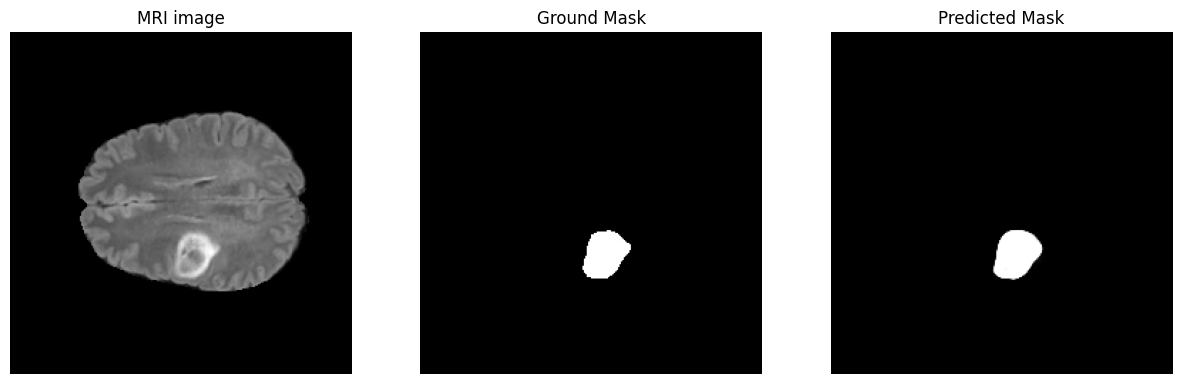

In [22]:
index = 5 # random number

pred_image = pred_out[0][index].numpy()*255.
seg_img = seg_data[0][index]*255.
main_img = main_img_data[0][index]*255.

fig = plt.figure(figsize=(15,25))

plt.subplot(1, 3, 1)
plt.imshow(main_img, cmap='gray')
plt.axis("off")
plt.title("MRI image")

plt.subplot(1, 3, 2)
plt.imshow(seg_img, cmap='gray')
plt.axis("off")
plt.title("Ground Mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_image, cmap='gray')
plt.axis("off")
plt.title("Predicted Mask")
# print(np.sum(output[0][0] == 0))